**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        
        sample['image'] = self.transform(sample['image']).float()
        sample['mask'] = self.transform(sample['mask']).float()

        return sample

In [3]:
X_train_val = get_paths("data/train/images")
y_train_val = get_paths("data/train/gt")

transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
X_train_val[0]

'data/train/images/0_um_000000.png'

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                  y_train_val, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  shuffle=True)

In [6]:
train_dataset = RoadDataset(X_train, y_train, transform)

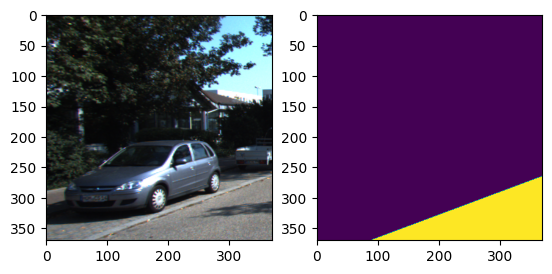

In [7]:
sample = train_dataset[110]
image = sample['image']
mask = sample['mask']

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0))

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [8]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 518


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [9]:
def calc_iou(prediction, ground_truth):
    EPS = 1.e-10
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return (float(intersection) + EPS) / (union + EPS)

In [10]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]

In [11]:
import gc
import glob
import torch
import segmentation_models_pytorch as smp
import albumentations as A
from tqdm import tqdm

device = torch.device("cuda:0")

In [12]:
model = smp.UnetPlusPlus(encoder_name='resnet18', 
                         encoder_weights='imagenet', 
                         in_channels=3, 
                         classes=1)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

aug = A.Compose([
                A.PadIfNeeded(min_height=512, min_width=512, p=1.),
                A.CenterCrop(height=512, width=512, p=1.)
                ])

trn_dataset = RoadDataset(X_train, y_train, transform, aug)
val_dataset = RoadDataset(X_val, y_val, transform, aug)

trn_loader = torch.utils.data.DataLoader(trn_dataset, 
                                         batch_size=2, 
                                         shuffle=True, 
                                         pin_memory=True,
                                         num_workers=24,
                                         prefetch_factor=2)

val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=1, 
                                         shuffle=False, 
                                         pin_memory=True,
                                         num_workers=24,
                                         prefetch_factor=2)


In [13]:
def train_epoch(model, 
                train_loader, 
                criterion, 
                scheduler, 
                optimizer,
                device):
    model.train()
    losses = []
    ious = []
    for sample in tqdm(trn_loader):
        images = sample["image"].to(device)
        masks = sample["mask"].to(device)
        
        y_pred = model(images)
    
        loss = criterion(y_pred, masks)
        loss.backward()
        optimizer.step()
        y_pred = torch.nn.Sigmoid()(y_pred)
        y_pred = (y_pred > 0.5)
        iou = calc_iou(y_pred.detach().cpu().numpy(), masks.detach().cpu().numpy())
        losses.append(loss.item())
        ious.append(iou)
    optimizer.zero_grad()
    torch.cuda.empty_cache()
    gc.collect()
    return np.mean(losses, axis = 0), np.mean(ious, axis = 0)

@torch.no_grad()
def val_epoch(model, 
              dataloader,
              criterion,
              scheduler,
              device):

    model.eval()
    losses = []
    ious = []
    
    for sample in tqdm(dataloader):
        images = sample["image"].to(device)
        masks = sample["mask"].to(device)
        
        y_pred  = model(images)
        
        loss = criterion(y_pred, masks)
        
        y_pred = torch.nn.Sigmoid()(y_pred)
        y_pred = (y_pred > 0.5)
        
        iou = calc_iou(masks.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        losses.append(loss.item())
        ious.append(iou)
        
    scheduler.step()
    
    iou  = np.mean(ious, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return np.mean(losses, axis=0), np.mean(ious, axis=0)



In [14]:
from segmentation_models_pytorch.losses import DiceLoss

In [15]:
dice = DiceLoss(mode='binary')

In [16]:
# iou>0.87
results = {"train": {"loss": [], "iou":[]},
           "val":   {"loss": [], "iou":[]}}

for i in range(50):
    trn_loss, trn_iou = train_epoch(model, trn_loader, dice, scheduler, optimizer, device)
    val_loss, val_iou = val_epoch(model, val_loader, dice, scheduler, device)
    results["train"]["loss"].append(trn_loss)
    results["train"]["iou"].append(trn_iou)
    results["val"]["loss"].append(val_loss)
    results["val"]["iou"].append(val_iou)
    print(f"loss: {val_loss}, iou: {val_iou}")


100%|██████████| 130/130 [00:04<00:00, 27.53it/s]


loss: 0.32719539403915404, iou: 0.5428168414590392


100%|██████████| 130/130 [00:04<00:00, 28.11it/s]


loss: 0.3230819202386416, iou: 0.5585474997981604


100%|██████████| 130/130 [00:04<00:00, 28.38it/s]


loss: 0.24698735337990982, iou: 0.6380868846178043


100%|██████████| 130/130 [00:04<00:00, 28.33it/s]


loss: 0.32342281479101914, iou: 0.5527767812295974


100%|██████████| 130/130 [00:04<00:00, 27.86it/s]


loss: 0.26324632718012886, iou: 0.6271955180028383


100%|██████████| 130/130 [00:04<00:00, 29.63it/s]


loss: 0.28991185014064497, iou: 0.5861873983853063


100%|██████████| 130/130 [00:04<00:00, 29.72it/s]


loss: 0.2859072167139787, iou: 0.6032963442763601


100%|██████████| 130/130 [00:04<00:00, 28.19it/s]


loss: 0.2865734806427589, iou: 0.5906715349981643


100%|██████████| 130/130 [00:04<00:00, 28.73it/s]


loss: 0.24365018560336185, iou: 0.640737046987345


100%|██████████| 130/130 [00:04<00:00, 27.65it/s]


loss: 0.24285743053142841, iou: 0.6393516346945654


100%|██████████| 130/130 [00:04<00:00, 28.42it/s]


loss: 0.2651955755857321, iou: 0.6113184089912559


100%|██████████| 130/130 [00:04<00:00, 27.58it/s]


loss: 0.24498267953212444, iou: 0.6407338517907619


100%|██████████| 130/130 [00:04<00:00, 27.56it/s]


loss: 0.22598791214135977, iou: 0.6698230482463953


100%|██████████| 130/130 [00:05<00:00, 25.70it/s]


loss: 0.2568205659206097, iou: 0.6249862336551715


100%|██████████| 130/130 [00:04<00:00, 28.08it/s]


loss: 0.26412898485477154, iou: 0.6286899479548421


100%|██████████| 130/130 [00:04<00:00, 27.35it/s]


loss: 0.23491123135273273, iou: 0.6556940803782325


100%|██████████| 130/130 [00:04<00:00, 29.64it/s]


loss: 0.23275441573216366, iou: 0.6641212376694736


100%|██████████| 130/130 [00:04<00:00, 27.88it/s]


loss: 0.22933463912743787, iou: 0.672685403054892


100%|██████████| 130/130 [00:04<00:00, 26.45it/s]


loss: 0.22306849177067095, iou: 0.6731379955296645


100%|██████████| 130/130 [00:04<00:00, 27.42it/s]


loss: 0.2374977185175969, iou: 0.6567262234816817


100%|██████████| 130/130 [00:04<00:00, 28.01it/s]


loss: 0.22578241137357857, iou: 0.6736786625259764


100%|██████████| 130/130 [00:04<00:00, 26.70it/s]


loss: 0.23427896178685703, iou: 0.6536394403232173


100%|██████████| 130/130 [00:04<00:00, 27.04it/s]


loss: 0.21837891752903277, iou: 0.6781968731809166


100%|██████████| 130/130 [00:04<00:00, 28.53it/s]


loss: 0.24150899373568022, iou: 0.6620690460334905


100%|██████████| 130/130 [00:04<00:00, 28.09it/s]


loss: 0.2298487819158114, iou: 0.6737694853389387


100%|██████████| 130/130 [00:04<00:00, 30.05it/s]


loss: 0.22087076214643625, iou: 0.6834220127162951


100%|██████████| 130/130 [00:04<00:00, 30.19it/s]


loss: 0.26766029458779556, iou: 0.622187325859388


100%|██████████| 130/130 [00:04<00:00, 29.16it/s]


loss: 0.23956413314892697, iou: 0.6622348932313892


100%|██████████| 130/130 [00:04<00:00, 28.31it/s]


loss: 0.2004675369996291, iou: 0.695264633782008


100%|██████████| 130/130 [00:04<00:00, 28.12it/s]


loss: 0.20426089947040266, iou: 0.6851421589425801


100%|██████████| 130/130 [00:04<00:00, 27.94it/s]


loss: 0.2235355711900271, iou: 0.6731809433843848


100%|██████████| 130/130 [00:04<00:00, 27.33it/s]


loss: 0.1877907551251925, iou: 0.7002128510493039


100%|██████████| 130/130 [00:04<00:00, 28.05it/s]


loss: 0.2573168864616981, iou: 0.6331058199563728


100%|██████████| 130/130 [00:04<00:00, 27.27it/s]


loss: 0.21007174849510193, iou: 0.6881792349241365


100%|██████████| 130/130 [00:04<00:00, 28.76it/s]


loss: 0.19439706252171443, iou: 0.7042529489591525


100%|██████████| 130/130 [00:04<00:00, 27.08it/s]


loss: 0.1873040057145632, iou: 0.7102384388472671


100%|██████████| 130/130 [00:04<00:00, 27.11it/s]


loss: 0.22849863400826087, iou: 0.6772257407950314


100%|██████████| 130/130 [00:04<00:00, 27.75it/s]


loss: 0.22195721589601958, iou: 0.6904547133631451


100%|██████████| 130/130 [00:04<00:00, 27.48it/s]


loss: 0.19406898205096906, iou: 0.7052435220643737


100%|██████████| 130/130 [00:04<00:00, 28.22it/s]


loss: 0.214255442069127, iou: 0.6973882798160346


100%|██████████| 130/130 [00:04<00:00, 27.20it/s]


loss: 0.2006027721441709, iou: 0.6963606269261788


100%|██████████| 130/130 [00:04<00:00, 27.07it/s]


loss: 0.21027964995457576, iou: 0.692918874534305


100%|██████████| 130/130 [00:04<00:00, 27.75it/s]


loss: 0.20000937764461224, iou: 0.6981416262152488


100%|██████████| 130/130 [00:04<00:00, 28.79it/s]


loss: 0.2019298778130458, iou: 0.6951329191368426


100%|██████████| 130/130 [00:04<00:00, 28.75it/s]


loss: 0.20714563177182124, iou: 0.7041454146973187


100%|██████████| 130/130 [00:04<00:00, 28.69it/s]


loss: 0.1876408095543201, iou: 0.7111143009925671


100%|██████████| 130/130 [00:04<00:00, 27.90it/s]


loss: 0.20025959519239572, iou: 0.6954435727643287


100%|██████████| 130/130 [00:04<00:00, 27.49it/s]


loss: 0.19753949550481942, iou: 0.6992223302936734


100%|██████████| 130/130 [00:05<00:00, 25.45it/s]


loss: 0.20540911784538857, iou: 0.6908851693825596


100%|██████████| 130/130 [00:04<00:00, 27.93it/s]

loss: 0.19098548338963436, iou: 0.7060197745430621


In [17]:
import matplotlib.pyplot as plt

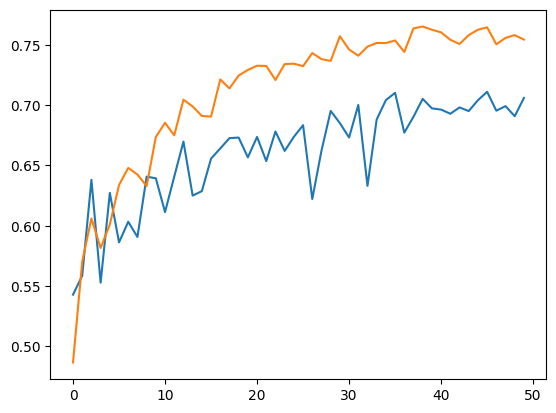

In [21]:
plt.plot(list(range(len(results["val"]["iou"]))), results["val"]["iou"])
plt.plot(list(range(len(results["train"]["iou"]))), results["train"]["iou"])

In [23]:
def test_model(model, dataloader, criterion, device):
    model.eval()
    losses = []
    ious = []
    
    for sample in tqdm(dataloader):
        images = sample["image"].to(device)
        masks = sample["mask"].to(device)
        
        y_pred  = model(images)
        
        loss = criterion(y_pred, masks)
        
        y_pred = torch.nn.Sigmoid()(y_pred)
        y_pred = (y_pred > 0.5)
        
        iou = calc_iou(masks.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        losses.append(loss.item())
        ious.append(iou)
    
    iou  = np.mean(ious, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return np.mean(losses, axis=0), np.mean(ious, axis=0)

In [24]:
test_model(model, val_loader, dice, device)

100%|██████████| 130/130 [00:04<00:00, 28.18it/s]


(0.19098548338963436, 0.7060197745430621)